In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay,classification_report
from sklearn.metrics import confusion_matrix, make_scorer, RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.classifier import ConfusionMatrix
from pandas.plotting import scatter_matrix
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_selection import SelectPercentile, SelectFromModel
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC

/kaggle/input/heart-attack-analysis-prediction-dataset/o2Saturation.csv
/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv


In [2]:
data = pd.read_csv('/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv')

# 1. Data Summary

In [3]:
data.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [5]:
data.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [6]:
data.corr()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trtbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalachh,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exng,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


# 2. Data Visualization

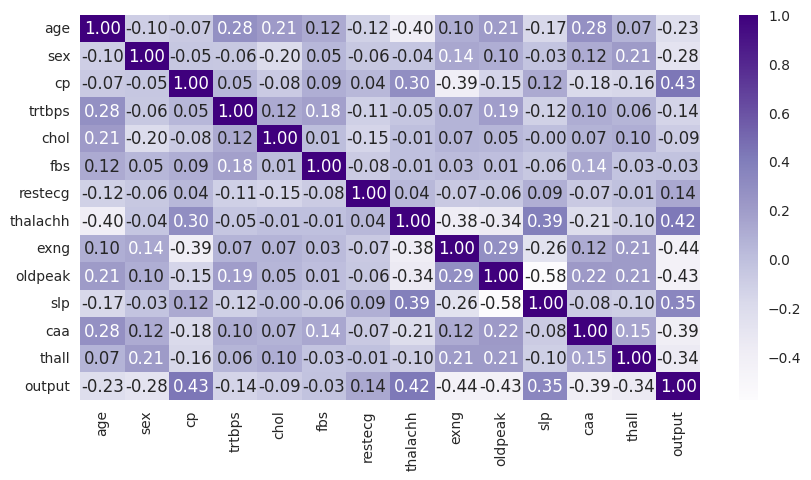

In [7]:
plt.figure(figsize=(10,5))
sns.heatmap(data.corr(), annot=True, cmap="Purples", fmt=".2f")
plt.show()

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'cp'}>,
        <Axes: title={'center': 'trtbps'}>],
       [<Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'fbs'}>,
        <Axes: title={'center': 'restecg'}>,
        <Axes: title={'center': 'thalachh'}>],
       [<Axes: title={'center': 'exng'}>,
        <Axes: title={'center': 'oldpeak'}>,
        <Axes: title={'center': 'slp'}>, <Axes: title={'center': 'caa'}>],
       [<Axes: title={'center': 'thall'}>,
        <Axes: title={'center': 'output'}>, <Axes: >, <Axes: >]],
      dtype=object)

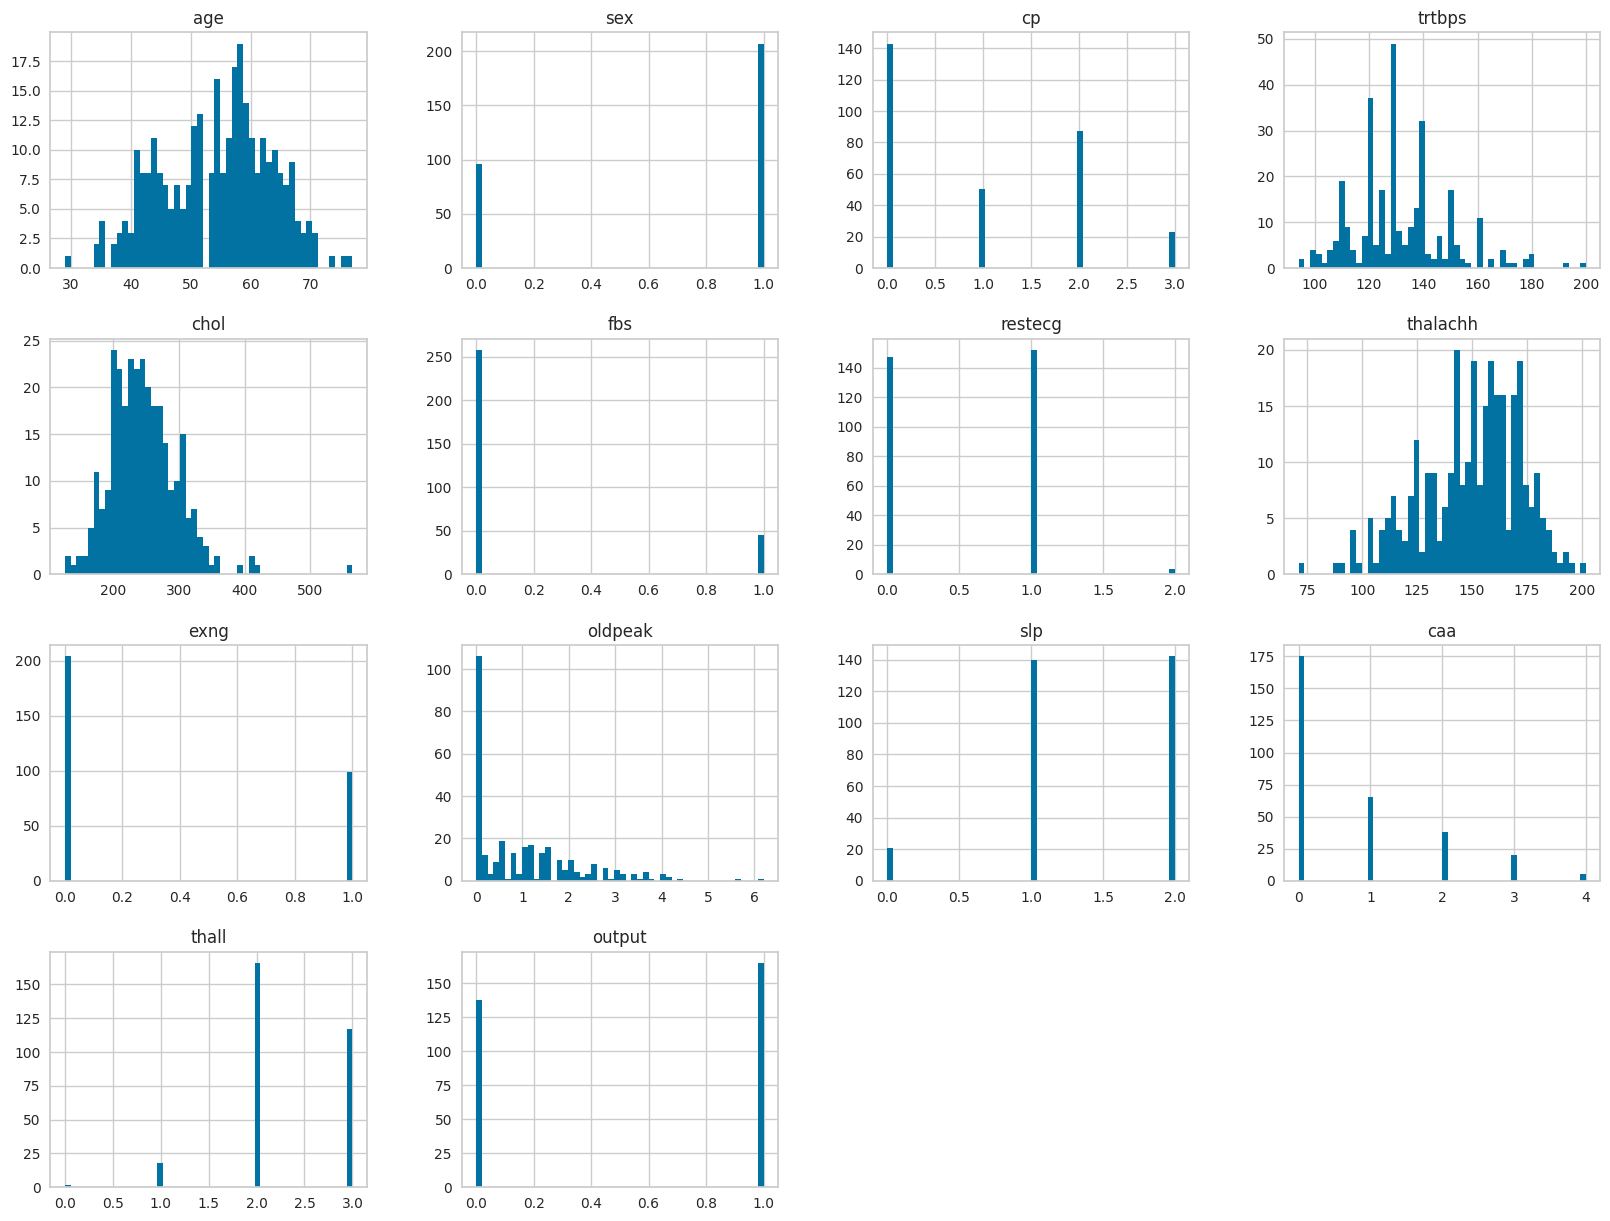

In [8]:
data.hist(bins=50, figsize=(20,15))

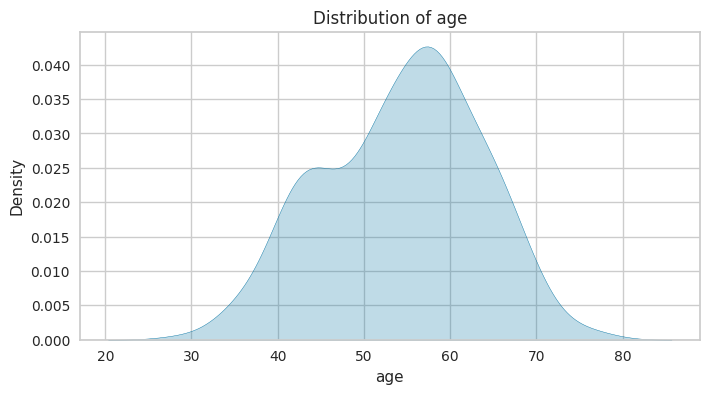

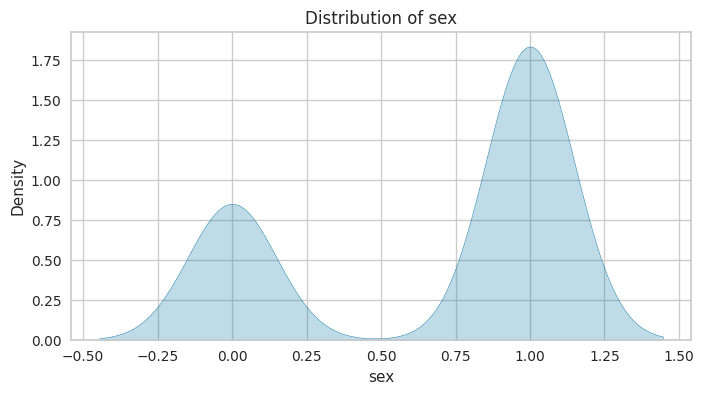

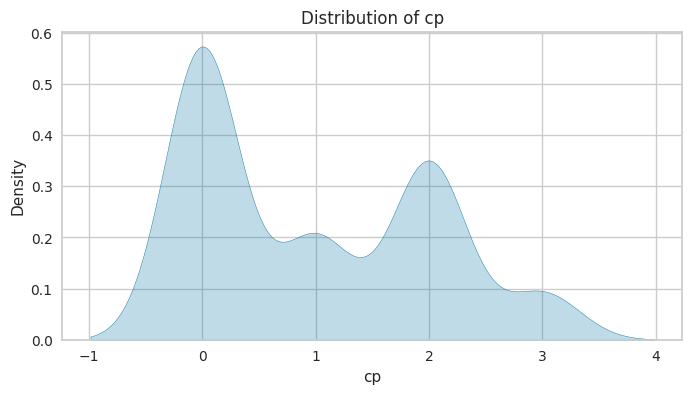

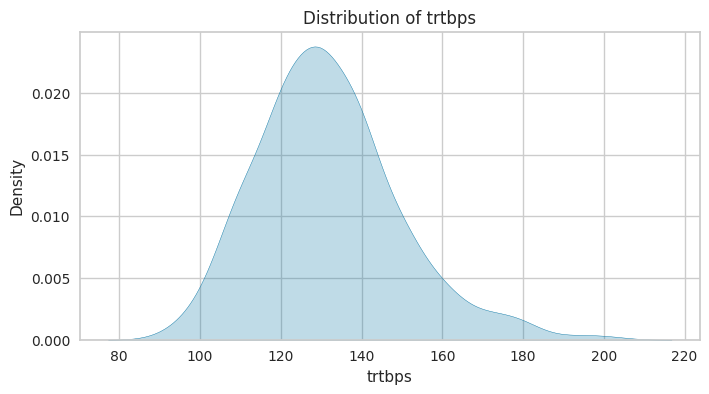

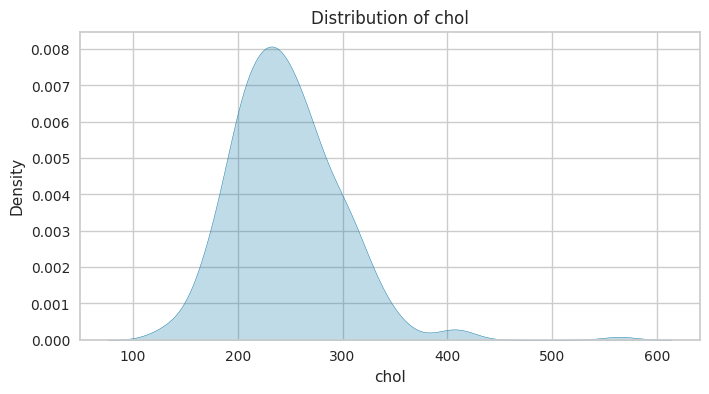

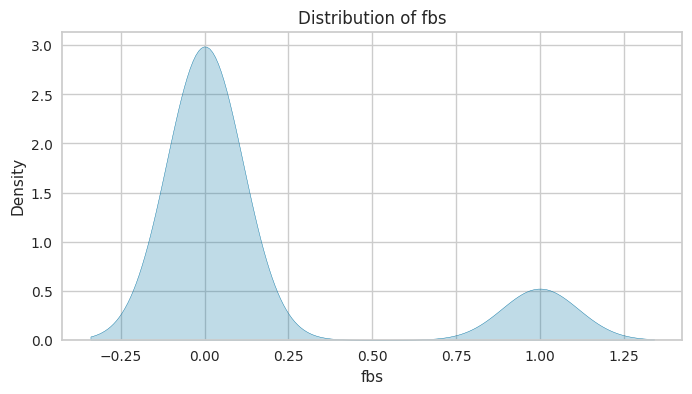

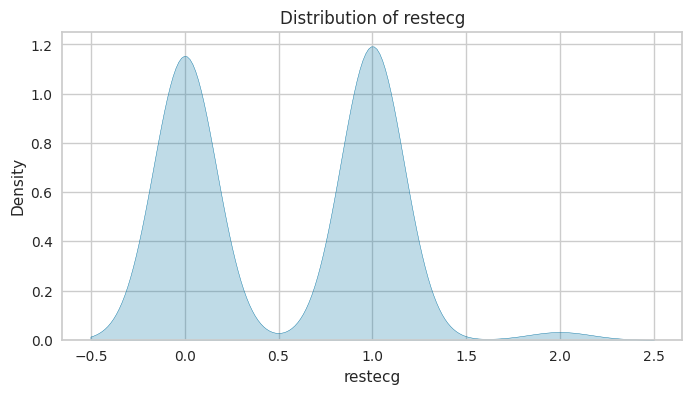

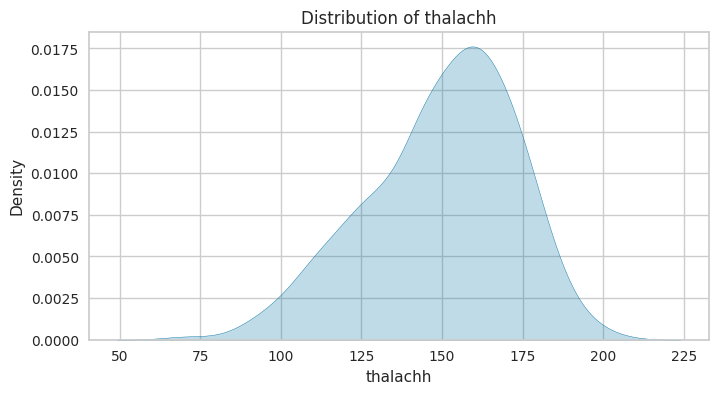

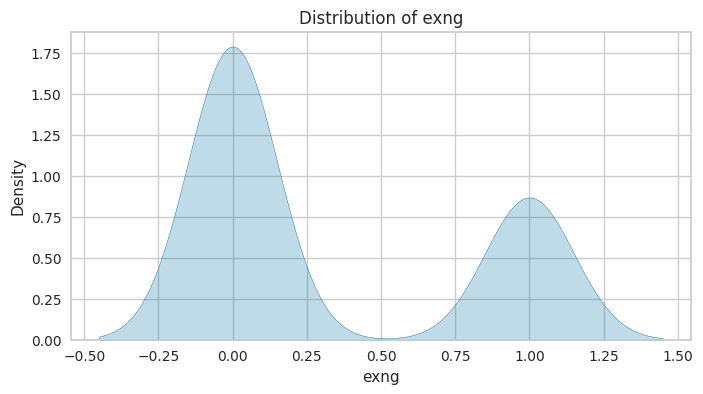

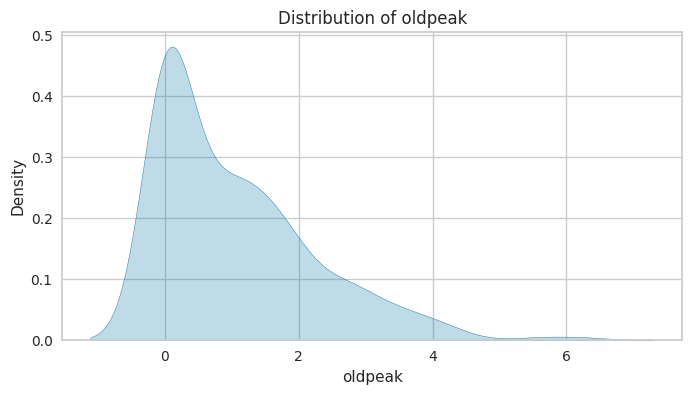

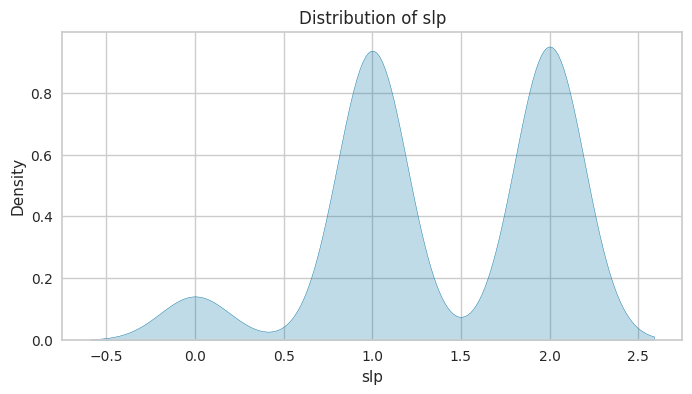

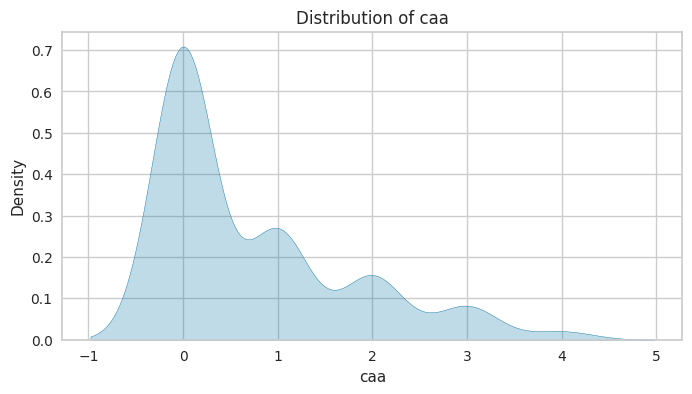

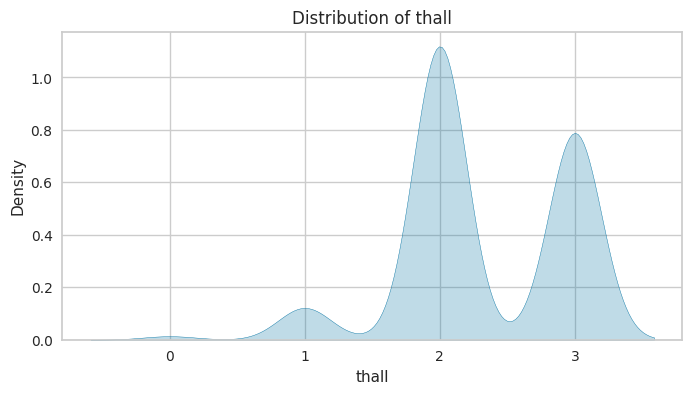

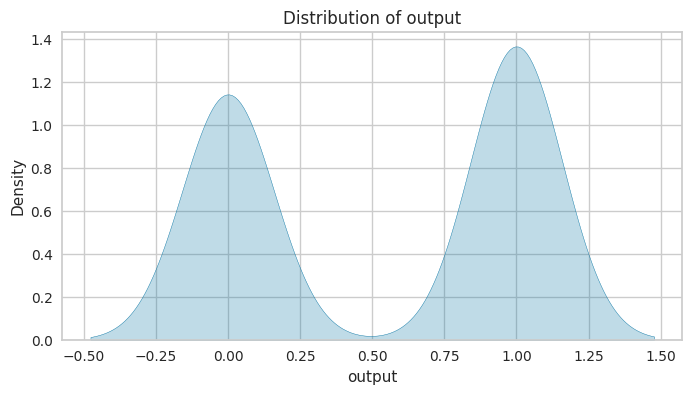

In [9]:
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=data[col],fill=True, legend=False)
    plt.title(f'Distribution of {col}')
    plt.show()
 

# 3. Data Cleaning

In [10]:
duplicated = data[data.duplicated()]
duplicated

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


In [11]:
data.drop_duplicates()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


# 4. Data Preprocessing

In [12]:
features = data.columns.drop('output')

In [13]:
X = data[features]
y = data['output']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
X_train.shape, y_train.shape

((242, 13), (242,))

In [16]:
X_test.shape, y_test.shape

((61, 13), (61,))

In [17]:
cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
num_cols = ['age','trtbps','chol','thalachh','oldpeak']

In [18]:
num_encoder = StandardScaler()

In [19]:
X_train[cat_cols] = pd.get_dummies(X_train[cat_cols])
X_test[cat_cols] = pd.get_dummies(X_test[cat_cols])

In [20]:
X_train[num_cols] = num_encoder.fit_transform(X_train[num_cols])
X_test[num_cols] = num_encoder.fit_transform(X_test[num_cols])

# 5. Decission Tree

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 270.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 889, in fit
    super().fit(
  File "/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py", line 177, in fit
    self._validate_params()
  File "/opt/conda/lib/python3.10/site-packages/sklearn/base.py", line 600, in _valida

Best score: 0.770
Best parameters set:
	criterion: 'entropy'
	max_depth: 150
	min_samples_leaf: 1
	min_samples_split: 3
Accuracy:0.8360655737704918
F1-Score:0.8333333333333334
Precision:0.8928571428571429
Recall:0.78125
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        29
           1       0.89      0.78      0.83        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



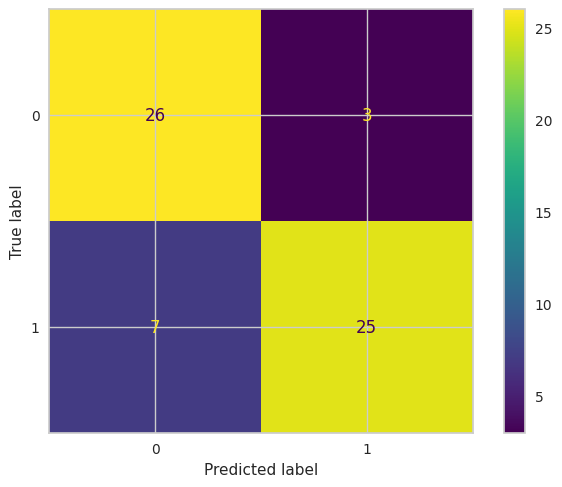

In [21]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=150, min_samples_leaf=1, min_samples_split=2, random_state=0)
dt_parameters = {
    'max_depth': (150, 155, 160),
    'min_samples_split': (1, 2, 3),
    'min_samples_leaf': (1, 2, 3),
    'criterion' :['gini', 'entropy']}
dt_grid_search = GridSearchCV(dt, dt_parameters, cv=5, n_jobs=-1,verbose=1, scoring='f1')
dt_grid_search.fit(X_train, y_train)
print ('Best score: %0.3f' % dt_grid_search.best_score_)
print ('Best parameters set:')
dt_best_parameters = dt_grid_search.best_estimator_.get_params()
for param_name in sorted(dt_parameters.keys()):
    print ('\t%s: %r' % (param_name, dt_best_parameters[param_name]))
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print(f"Accuracy:{accuracy_score(y_test, y_pred_dt)}")
print(f"F1-Score:{f1_score(y_test, y_pred_dt)}")
print(f"Precision:{precision_score(y_test, y_pred_dt)}")
print(f"Recall:{recall_score(y_test, y_pred_dt)}")
print (classification_report(y_test, y_pred_dt))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt)
plt.show()

# 6. Random Forest

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best score: 0.858
Best parameters set:
	criterion: 'gini'
	max_features: 1
	min_samples_leaf: 3
	min_samples_split: 3
	n_estimators: 500
Accuracy:0.819672131147541
F1-Score:0.8307692307692308
Precision:0.8181818181818182
Recall:0.84375
              precision    recall  f1-score   support

           0       0.82      0.79      0.81        29
           1       0.82      0.84      0.83        32

    accuracy                           0.82        61
   macro avg       0.82      0.82      0.82        61
weighted avg       0.82      0.82      0.82        61



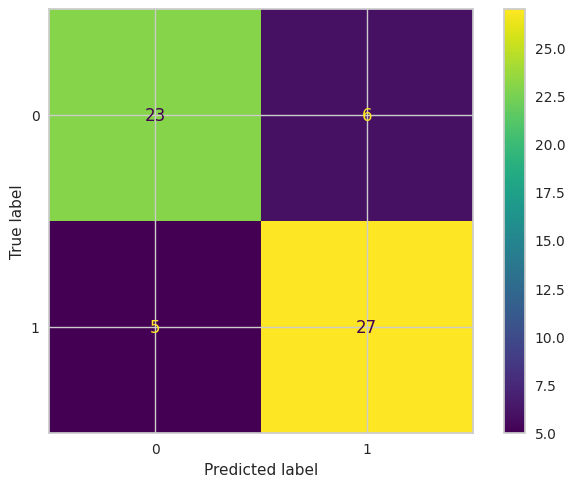

In [22]:
rf=RandomForestClassifier(criterion='entropy', max_features=10, min_samples_leaf=1, min_samples_split=2, n_estimators=400)
rf_parameters = {"max_features": [1,3,10],
              "min_samples_split":[2,3,10],
              "min_samples_leaf":[1,3,10],
              "n_estimators":[100,300, 400, 500],
              "criterion":["gini", "entropy"]}
rf_grid_search = GridSearchCV(rf, rf_parameters, cv=5, n_jobs=-1,verbose=1, scoring='f1')
rf_grid_search.fit(X_train, y_train)
print ('Best score: %0.3f' % rf_grid_search.best_score_)
print ('Best parameters set:')
rf_best_parameters = rf_grid_search.best_estimator_.get_params()
for param_name in sorted(rf_parameters.keys()):
    print ('\t%s: %r' % (param_name, rf_best_parameters[param_name]))
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f"Accuracy:{accuracy_score(y_test, y_pred_rf)}")
print(f"F1-Score:{f1_score(y_test, y_pred_rf)}")
print(f"Precision:{precision_score(y_test, y_pred_rf)}")
print(f"Recall:{recall_score(y_test, y_pred_rf)}")
print (classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.show()


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best score: 0.842
Best parameters set:
	C: 0.1
	kernel: 'linear'
Accuracy:0.8688524590163934
F1-Score:0.8787878787878787
Precision:0.8529411764705882
Recall:0.90625
              precision    recall  f1-score   support

           0       0.89      0.83      0.86        29
           1       0.85      0.91      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



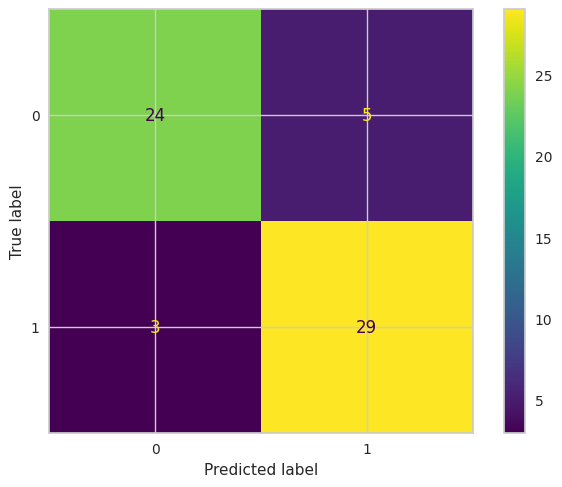

In [23]:
svm = SVC()
svm_parameters = {'C': [0.1, 1, 10], 
     'kernel': ['linear', 'rbf']}
svm_grid_search = GridSearchCV(svm, svm_parameters, cv=5, n_jobs=-1,verbose=1, scoring='f1')
svm_grid_search.fit(X_train, y_train)
print ('Best score: %0.3f' % svm_grid_search.best_score_)
print ('Best parameters set:')
best_parameters = svm_grid_search.best_estimator_.get_params()
for param_name in sorted(svm_parameters.keys()):
    print ('\t%s: %r' % (param_name, best_parameters[param_name]))
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print(f"Accuracy:{accuracy_score(y_test, y_pred_svm)}")
print(f"F1-Score:{f1_score(y_test, y_pred_svm)}")
print(f"Precision:{precision_score(y_test, y_pred_svm)}")
print(f"Recall:{recall_score(y_test, y_pred_svm)}")
print (classification_report(y_test, y_pred_svm))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm)
plt.show()